<a href="https://colab.research.google.com/github/Priyanka-Police-Reddy-Gari/MultiLabelClassification_StackExchange/blob/main/Priyanka_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Environment


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchinfo
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
from torchtext.vocab import vocab
from torchinfo import summary
from torchmetrics import HammingDistance

import random

import numpy as np

import joblib
from collections import Counter
from functools import partial
from pathlib import Path

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import sys
import ast

In [ ]:
basepath = '/content/drive/MyDrive/NLP'

In [ ]:
sys.path.append('/content/drive/MyDrive/NLP/data/custom-functions')

In [ ]:
basefolder = Path(basepath)
datafolder = basefolder/"Assignment_4/Data/"
modelfolder = basefolder/"Assignment_4/Model/"
customfolder = basefolder/"data/custom-functions/"

# Load Data


In [ ]:
multilabel_data = joblib.load(datafolder/'df_multilabel_hw_cleaned.joblib')

In [ ]:
multilabel_data

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [ ]:
multilabel_data['Tag_Number'].dtype

dtype('O')

In [ ]:
#Converting labels from Object to Integer
multilabel_data["Tag_Number"] = multilabel_data["Tag_Number"].apply(ast.literal_eval)

In [ ]:
X = multilabel_data.drop(["Tags","Tag_Number"],axis=1).values.tolist()
y = multilabel_data["Tag_Number"].values
X = list(map(str,X))

In [ ]:
type(y)

numpy.ndarray

In [ ]:
type(X)

list

In [ ]:
y

array([list([0, 9]), list([1, 3]), list([0, 9]), ..., list([1, 4]),
       list([9, 3]), list([3, 5])], dtype=object)

# One hot encoding using MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer()

In [ ]:
y = mlb.fit_transform(y)

In [ ]:
y

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y.shape

(47427, 10)

# Train - Test Split

In [ ]:
X_train,X_temp,y_train,y_temp = train_test_split( X, y, test_size=.4, random_state=42 )

In [ ]:
X_val,X_test,y_val,y_test = train_test_split( X_temp, y_temp, test_size=0.5, random_state=42)

# Custom Dataset Class

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [ ]:
trainset = CustomDataset(X_train,y_train)
valset = CustomDataset(X_val,y_val)
testset = CustomDataset(X_test,y_test)

In [ ]:
pprint(trainset[2])

(array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0]),
 "['send javascript variable php send value store javascript variable php page "
 'php page different folder javascript page javascript variable method fire '
 "click button   send variable value php page eclipse project']")


In [ ]:
text_of_2_sample = trainset[2][1]
pprint(text_of_2_sample)

("['send javascript variable php send value store javascript variable php page "
 'php page different folder javascript page javascript variable method fire '
 "click button   send variable value php page eclipse project']")


In [ ]:
label_of_2_sample = trainset[2][0]
pprint(label_of_2_sample)

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])


In [ ]:
type(text_of_2_sample)

str

In [ ]:
type(label_of_2_sample)

numpy.ndarray

# Create Vocab

In [ ]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (label, text) in dataset:
        counter.update(text.split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [ ]:
stack_ex_vocab = get_vocab(trainset,min_freq=2)

In [ ]:
len(stack_ex_vocab)

93067

In [ ]:
stack_ex_vocab.get_itos()[0:5]

['<unk>', "['rearrange", 'order', 'list', 'web']

In [ ]:
stack_ex_vocab['jadhoo']

0

# Collate_fn for Data Loaders

In [ ]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in x.split()]

In [ ]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.float)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return (indices, offsets), labels

# Check Collate Function #Can be removed

In [ ]:
batch_size = 2
collate_partial = partial(collate_batch, my_vocab = stack_ex_vocab)
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=collate_partial,
                                           )

In [ ]:
torch.manual_seed(22)
for (indices, offset), label in check_loader:
    print(indices, offset, label)
    break

tensor([  490,   131,  3442,  1183,  1044,   617,   800,   205,   537,   581,
           24,  1771,   581,     5,   451,  1840,   385,  3442,   581,   800,
          540, 25490,    31,   718,   581,   476,  2659,  1778,  1183,   194,
         2396,   523,   505,   476,  2659,   581,  1325,   523,   104,  1778,
          520,     0,     0,     0,  1537,  1645,   581,   104,   635, 35453,
          564, 30115,   117,   339,   330,   883, 49844,    89,  3422,   177,
        62789,    50,   210,   236,  1631,  3422,   177,    24,   473,  1631,
          177, 43476,  1457,   209,   236,  1631,    82,   177,   841,   163,
          439,    82,   439,   179,   439,   440,   439,   523,   439,   524,
          439,   526,   209,    77,   464,   451,  5898,    82,    82,    88,
         4880, 49820,   195,   564,   170,  7987,    82, 20623, 36924,  4879,
          799, 34190, 36925,  1762,   799, 34186, 36926, 36928, 36929,  1762,
          799, 34187, 36930, 36931, 36929,  1762,   799, 34188, 

# Custom Model Class

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, output_layer):
        super().__init__()


        # EmbeddingBag → Hidden_Layer1 →ReLU  → Dropout_Layer1 → BatchNorn_Layer1 → Hidden_Layer2 → ReLU  → DropoutLayer2 → BatchNorm_Layer2  → Output Layer

        # Embedding layer
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

        # First hidden Linear layer
        self.linear1 = nn.Linear(embedding_dim, hidden_dim1)

        # Dropout for first linear layer
        self.dropout1 = nn.Dropout(p=drop_prob1)

        # Batch normalization for first linear layer
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)


        # Second Linear layer
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)

        # Dropout for second linear layer
        self.dropout2 = nn.Dropout(p=drop_prob2)

        # Batch normalization for second linear layer
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)


        # Final Linear layer
        self.output = nn.Linear(hidden_dim2, output_layer)

    def forward(self, input_tuple):
        indices, offsets = input_tuple

        # Pass data through the embedding layer
        x = self.embedding_bag(indices, offsets)

        # First linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)


        # Second linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)


        # Final linear layer
        x = self.output(x)

        return x


In [ ]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
# this will invoke the __init__() function of the model
model = SimpleMLP(vocab_size=7 , embedding_dim=10, hidden_dim1=5, hidden_dim2=3, drop_prob1=0.5, drop_prob2=0.5, output_layer=2)

# Move the model to the device
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model, input_data=[(data, offsets)], device=device, depth =10, verbose = False)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleMLP                                [3, 2]                    --
├─EmbeddingBag: 1-1                      [3, 10]                   70
├─Linear: 1-2                            [3, 5]                    55
├─Dropout: 1-3                           [3, 5]                    --
├─BatchNorm1d: 1-4                       [3, 5]                    10
├─Linear: 1-5                            [3, 3]                    18
├─Dropout: 1-6                           [3, 3]                    --
├─BatchNorm1d: 1-7                       [3, 3]                    6
├─Linear: 1-8                            [3, 2]                    8
Total params: 167
Trainable params: 167
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
train_metric = HammingDistance(task="multilabel",num_labels=10)

In [ ]:
train_metric

MultilabelHammingDistance()

# Functions to train and eval models

## step() Function

In [ ]:
def step( model, inputs, targets, device, loss_function, optimizer=None, clip_value = None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    train_metric.to(device)
    model = model.to(device)
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    # predicted = torch.argmax(outputs.data, 1)
    # correct = (predicted == targets).sum().item()

    y_pred = (outputs.data > 0.5).float()
    train_metric.update(y_pred,targets)
    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(),clip_value=CLIP_VALUE)
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, train_metric
    else:
        return None, outputs, train_metric


## Train() Epoch

In [ ]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    # running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, hammingdistance = step(model, inputs, targets, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        # running_train_correct += correct
        train_epoch_hammingdistance = hammingdistance.compute()

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    # train_acc = running_train_correct / len(train_loader.dataset)

    return train_loss, train_epoch_hammingdistance

## Validation() Epoch

In [ ]:
def val_epoch(val_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    # running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in val_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, hammingdistance = step(model, inputs, targets, device, loss_function)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            # running_val_correct += correct
            val_epoch_hammingdistance = hammingdistance.compute()

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(val_loader)
    # val_acc = running_val_correct / len(valid_loader.dataset)

    return val_loss, val_epoch_hammingdistance

## Train Function

In [ ]:
def train(train_loader, val_loader, model,device, loss_function, optimizer, epochs):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    """
    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    val_loss_history = []
    train_hd_history = []
    val_hd_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_hd = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        val_loss, val_hd = val_epoch(
            val_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_hd_history.append(train_hd)
        val_loss_history.append(val_loss)
        val_hd_history.append(val_hd)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_hd:.4f}")
        print(f"Valid Loss: {val_loss:.4f} | Valid Hamming Distance: {val_hd:.4f}")
        print()

    return train_loss_history, train_hd_history, val_loss_history, val_hd_history


# Train Model


## Hyperparameters

In [ ]:
# model Parameters
EMBED_DIM=300
VOCAB_SIZE=len(stack_ex_vocab)
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=10

# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.000
CLIP_VALUE=10

## Training Configuration

In [ ]:
# Define the loss function for the model
loss_function = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Define collate function with a fixed vocabulary using the 'partial' function
collate_fn = partial(collate_batch, my_vocab=stack_ex_vocab)

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn, num_workers=4)

# Define the model with specified hyperparameters
model_stack_ex = SimpleMLP(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBED_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       output_layer=NUM_OUTPUTS)

# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = torch.optim.AdamW(model_stack_ex.parameters(), lr=LEARNING_RATE)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Sanity Check

In [ ]:
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device)
    print(targets)
    print(targets.dtype)
    model_stack_ex = model_stack_ex.to(device)
    model_stack_ex.eval()
    print(f'Input data type: {inputs[0].dtype}')
    print(f'Target data type: {targets.dtype}')
    with torch.no_grad():
        output = model_stack_ex(inputs)
        print("Output type",output.dtype)
        print(loss_function)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])
torch.float32
Input data type: torch.int64
Target data type: torch.float32
Output type torch.float32
BCEWithLogitsLoss()
Actual loss: 0.6980595588684082
Expected Theoretical loss: 0.6931471805599453


## Training

In [ ]:
train_losses, train_dis, valid_losses, valid_dis = train(
    train_loader, val_loader, model_stack_ex, device, loss_function, optimizer, EPOCHS
)


Epoch 1/5
Train Loss: 0.4006 | Train Hamming Distance: 0.1188
Valid Loss: 0.1794 | Valid Hamming Distance: 0.1056

Epoch 2/5
Train Loss: 0.1717 | Train Hamming Distance: 0.0876
Valid Loss: 0.1408 | Valid Hamming Distance: 0.0832

Epoch 3/5
Train Loss: 0.1398 | Train Hamming Distance: 0.0748
Valid Loss: 0.1261 | Valid Hamming Distance: 0.0725

Epoch 4/5
Train Loss: 0.1191 | Train Hamming Distance: 0.0669
Valid Loss: 0.1166 | Valid Hamming Distance: 0.0654

Epoch 5/5
Train Loss: 0.1046 | Train Hamming Distance: 0.0614
Valid Loss: 0.1107 | Valid Hamming Distance: 0.0604



In [ ]:
len(trainset.X)

28456

In [ ]:
len(trainset.y)

28456

## Plot Losses and Metrics

In [ ]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric-Hamming Distance")
        plt.legend()
        plt.show()
    return train_losses


In [ ]:
print(train_dis)

[tensor(0.1188), tensor(0.0876), tensor(0.0748), tensor(0.0669), tensor(0.0614)]


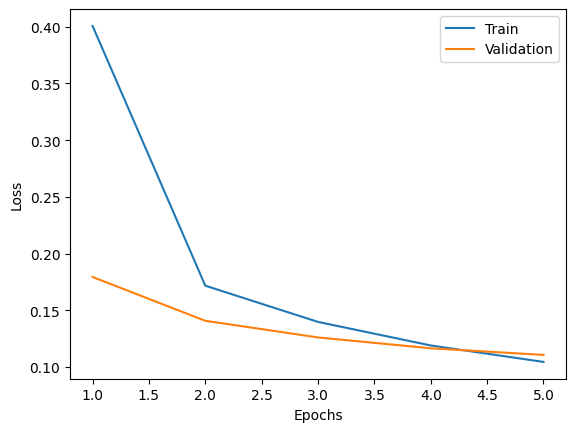

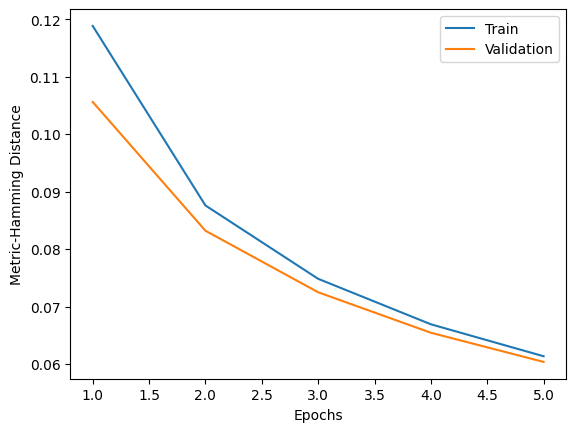

[0.400637482915224,
 0.1717298187215232,
 0.13980362059824136,
 0.11905421901310506,
 0.10455065938923926]

In [ ]:
plot_history(train_losses, train_dis, valid_losses, valid_dis)

## Model Checking

In [ ]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'model_parta'

# Combine the timestamp and suffix to create the file path
path = modelfolder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/NLP/Assignment_4/Model/2024-03-04_05-55-16_model_parta.pt')

In [ ]:
# Save the model's state dictionary to the specified file path
torch.save(model_stack_ex.state_dict(), path)

In [ ]:
stackmodel = SimpleMLP(vocab_size = VOCAB_SIZE,embedding_dim=EMBED_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       output_layer=NUM_OUTPUTS)
checkpoint = torch.load(path)
stackmodel.load_state_dict(checkpoint)

<All keys matched successfully>

## Eval Model on val dataset

In [ ]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    train_metric.to(device)
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    # running_correct = 0
    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            _, outputs,_ = step(model,inputs, targets,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            # _, predicted = torch.max(outputs.data, 1)
            y_pred = (outputs.data>0.5).float()

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, y_pred))
            y = torch.cat((y, targets.to(device)))

             # Calculate hamming dist
            hammingdistance = train_metric(y_pred,targets)

    # Return tuple containing predictions and accuracy
    return predictions, hammingdistance, y

## Predictions

In [ ]:
#Predictons
predictions_test, hd_test, y_test = get_acc_pred(test_loader, stackmodel, device)
predictions_train, hd_train, y_train = get_acc_pred(train_loader, stackmodel, device)
predictions_valid, hd_val, y_valid = get_acc_pred(val_loader, stackmodel, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#Predicted hamming distance
print('Test distance', hd_test)
print('Train distance', hd_train)
print('Valid distance', hd_val)

Test distance tensor(0.0357)
Train distance tensor(0.0400)
Valid distance tensor(0.0615)


In [ ]:
sample_X = X_test[5]
pprint(sample_X)

("['split 3 letter stringbuilder stringbuilder stringbuilder s = new "
 'stringbuilder   output s.tostring = abcdefg   want 3 letter beginning like '
 "abc code need use']")


In [ ]:
device = 'cpu'
list_of_list_of_indices = [tokenizer(text, stack_ex_vocab) for text in sample_X]
offsets_1 = [0] + [len(i) for i in list_of_list_of_indices]
offsets_1 = torch.tensor(offsets[:-1]).cumsum(dim=0)
indices_1 = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

<ipython-input-127-4b723febde95>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  offsets_1 = torch.tensor(offsets[:-1]).cumsum(dim=0)


## Inference

In [ ]:
stackmodel.to(device)
stackmodel.eval()
outputs_1 = stackmodel((indices_1, offsets_1))

In [ ]:
pred_1 = torch.argmax(outputs_1, dim = 1)
mapping_1 = {0: 'c#', 1: 'java' , 2: 'php',3:'javascript',4:'android',5:'jquery',6:'c++',7:'python',8:'iphone',9:'asp.net'}
pred_label_names = list(map(mapping_1.get, pred_1.tolist()))
print(pred_label_names)

['javascript', 'jquery']
